# Vector 1: Geopandas, Coordinate Systems, Projections
UW Geospatial Data Analysis  
CEE498/CEWA599  
David Shean

# Goals
* Review some fundamental concepts that are common to most geospatial analysis
* Learn basic operations with Geopandas
* Explore coordinate systems, projections and transformations, geometry types
* Create more sophisticated visualizations involving multiple layers and data types

## Key modules and packages
Multiple levels of open-source  
* geopandas - high-level vector processing (most of what we'll do), with dependencies:
    * shapely (Python interface to `GEOS`) https://shapely.readthedocs.io/en/latest/manual.html
        * GEOS https://trac.osgeo.org/geos/
        * Handles geometry, spatial operations
    * fiona (interface to GDAL/OGR) https://fiona.readthedocs.io/en/latest/README.html
        * GDAL/OGR https://gdal.org/
        * File input and output
    * pyproj (interface to PROJ)
        * PROJ https://proj.org/
        * Cartographic projections and coordinate transformations library
    * numpy
    * pandas

# Lab Exercises

## Import necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona

In [2]:
#%matplotlib widget
%matplotlib inline

# Part 1: Projections

There are many excellent references out there about coordinate systems and map projections.  I'm not going to try to reproduce here.  If you're relatively new to all of this, please review:
* http://resources.esri.com/help/9.3/arcgisengine/dotnet/89b720a5-7339-44b0-8b58-0f5bf2843393.htm
* http://maps.unomaha.edu/Peterson/gis/notes/MapProjCoord.html
* http://downloads2.esri.com/support/documentation/ao_/710Understanding_Map_Projections.pdf
* https://courses.washington.edu/gis250/lessons/projection/

I particularly like this poster from the USGS: https://pubs.er.usgs.gov/publication/70047422

## Load sample data: polygons of all countries in the world
* This is conveniently bundled with Geopandas
* Don't worry about syntax at this point, we'll get into details later

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

## Check the coordinate reference system (crs)

In [4]:
world.crs

{'init': 'epsg:4326'}

## Look up this EPSG code online (and burn it into your brain)
* What is this coordinate system?
* What are units?

In [5]:
#fiona.crs.to_string(fiona.crs.from_epsg(4326))

## Plot the GeoDataFrame using the built-in geopandas `plot` function with default settings

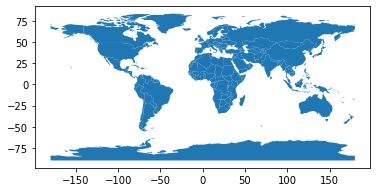

In [6]:
world.plot();

## Define a custom projection centered on the (self-proclaimed) "Center of the Universe" – Fremont, Seattle, WA, Earth
* https://www.atlasobscura.com/places/center-of-the-universe-sign
* You'll probably need to look up some coordinates on the web
* You will want to create a proj string (make sure you use sufficient precision for your decimal)
    * https://proj.org/usage/quickstart.html
* Choose a simple projection that accepts a center latitude and center longitude (e.g., orthographic)
    * See reference: https://proj.org/operations/projections/ortho.html
* Make sure you get your latitude and longitude order correct (do sanity check!)

In [7]:
cotu_coord = (47.6062, -122.3321)

In [8]:
local_proj_str = '+proj=ortho +lat_0=%0.7f +lon_0=%0.7f +datum=WGS84 +units=m +no_defs ' % cotu_coord

In [9]:
local_proj_str

'+proj=ortho +lat_0=47.6062000 +lon_0=-122.3321000 +datum=WGS84 +units=m +no_defs '

## Transform the world!
* Use GeoPandas `to_crs()` method to reproject the `world` GeoDataFrame to your local projection, centered on the center of the universe, reducing our beautiful [multidimensional universe](http://mentalfloss.com/article/501926/how-many-dimensions-are-there) to a 2D plot
* Note where the origin (0,0) is located
    * Plot a thin, black horizontal line where y=0 and a vertical line where x=0, producing "crosshairs"
    * See the matplotlib `axvline()` and `axhline()` methods
* See documentation here: http://geopandas.org/projections.html

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


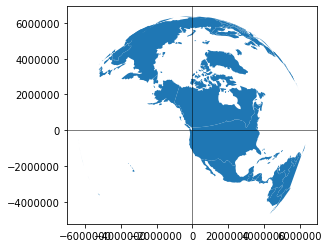

In [10]:
ax = world.to_crs(local_proj_str).plot()
ax.axvline(0, color='k', lw=0.5)
ax.axhline(0, color='k', lw=0.5);

## Wow, that was easy!
* Let's experiment with a few additional projections
* This time, use EPSG codes
    * Note that some documentation on web is outdated, using the old `init` syntax
    * See latest options here: https://geopandas.readthedocs.io/en/latest/projections.html#
    * Also: https://pyproj4.github.io/pyproj/dev/gotchas.html#init-auth-auth-code-should-be-replaced-with-auth-auth-code
* Try the following EPSG codes:
    * EPSG:3031 - South Polar Stereographic (see if you can find Antarctica)
    * EPSG:3857 - web mercator (format for most tiles like Google Satellite)
    * The EPSG code for the UTM zone that contains Seattle
        * see https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system
    * One or more additional EPSG codes of your choosing

## OK, that was also easy, but something isn't right
* Note some polygons (countries) that cross the antimeridian (-180°/+180° lon) or one of the poles (+90° or -90° lat, like, say Antarctica) may not render correctly
    * If using a regional projection for regional analysis (e.g., UTM for WA state), you probably wouldn't want to include polygons from the other side of the planet anyway. 
    * If you're working with a global dataset, you  can extract only polygons of interest before reprojecting.

## Isolate polygons from North America and repeat the above reprojections
* Start with a quick inspection of the `world` GeoDataFrame
* You should be able to use a simple boolean statement to return records for North American countries
    * Store the output in a new GeoDataFrame
* Rerun the same reprojection tests on this new GeoDataFrame

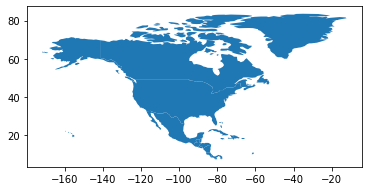

In [12]:
world_na = world[world['continent'] == 'North America']
world_na.plot();

## That looks better
* Check out: https://bl.ocks.org/syntagmatic/ba569633d51ebec6ec6e and https://www.jasondavies.com/maps/transition/ for interactive visualizations
* Also, https://xkcd.com/977/

## Global Projection Tradeoffs and Map Distortion - Tissot example

All map projections distort area, distance and angle.  The cartogrophers job is to select the best projection for the data and objectives of the map.

We're not going to get into `cartopy` this week, but I created the following function to show the classic [Tissot indicatrix](https://en.wikipedia.org/wiki/Tissot%27s_indicatrix) example, which helps to visualize distortion in different projections.

In [13]:
#Function to create cartopy plot with Tissot circles for input crs
def tissotplot(crs):
    fig, ax = plt.subplots(subplot_kw={'projection': crs})
    lons = range(-180, 180, 20)
    lats = range(-90, 90, 20)
    ax.coastlines()
    #ax.stock_img()
    ax.tissot(facecolor='orange', alpha=0.4, rad_km=500, lons=lons, lats=lats)
    ax.set_title('%s\n%s' % (crs, crs.proj4_init), fontsize=8)
    ax.set_global()
    #ax.add_geometries(world_proj['geometry'], crs=crs)
    return ax

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17ee23c50> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


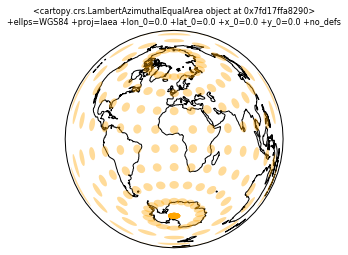

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17edbce90> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


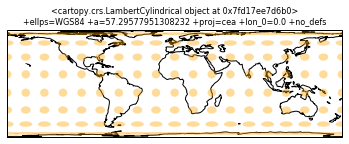

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17ed14f50> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


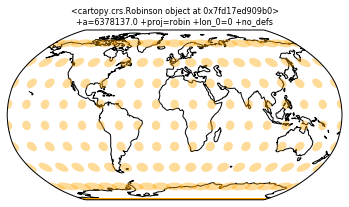

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17eceaf50> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


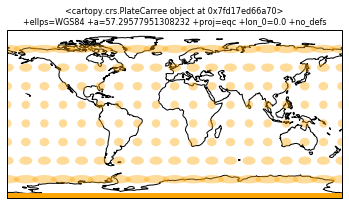

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17ecc0e90> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


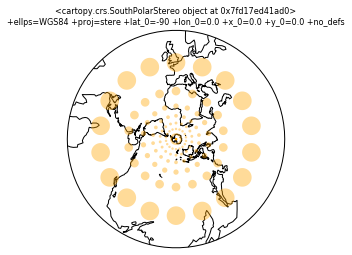

/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:632: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7fd17ec17e30> with the PlateCarree projection.
  'PlateCarree projection.'.format(crs))


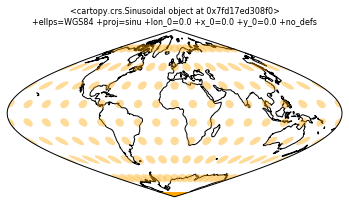

In [14]:
import cartopy.crs as ccrs

tissotplot(ccrs.LambertAzimuthalEqualArea())
tissotplot(ccrs.LambertCylindrical())
tissotplot(ccrs.Robinson())
tissotplot(ccrs.PlateCarree())
tissotplot(ccrs.SouthPolarStereo())
tissotplot(ccrs.Sinusoidal())

## OK, those are nice.
## Now look at them and discuss the following with your neighbor
* Which of the above projection has the greatest area distortion?  How can you tell?
    * If you skipped it, maybe go back and read about what the Tissot circles mean
* Which has greatest azimuthal distortion?

This might be a useful resource: https://www.esri.com/arcgis-blog/products/product/mapping/tissots-indicatrix-helps-illustrate-map-projection-distortion/

# Part 2: ICESat may be dead, but the points live on...
* Let's continue to play with the CONUS GLAS dataset to explore projections
* Let's move beyond basic NumPy and Pandas from last week, and start using the more capable GeoPandas package

## Load the existing csv into a Pandas DataFrame
* May need to update the file path based on how you are organizing the modules

In [15]:
glas_fn = '../01_Shell_Github/data/GLAH14_tllz_conus_lulcfilt_demfilt.csv'
glas_df = pd.read_csv(glas_fn)

In [16]:
glas_df.head()

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31


## Convert the Pandas `DataFrame` to a GeoPandas `GeoDataFrame`
* https://geopandas.readthedocs.io/en/latest/gallery/create_geopandas_from_pandas.html
* Careful about lon and lat order!
* Run a quick `head()` to make sure everything looks good
* Note the new `geometry` column of the GeoDataFrame

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (-105.35656 44.15790)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (-105.35812 44.15017)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (-105.35843 44.14863)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (-105.35874 44.14709)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (-105.35905 44.14554)


## A note on `Point` geometry objects
* The coordiantes in the special `geometry` column of a `GeoDataFrame` are actually `Point` objects from the Shapely library
    * https://shapely.readthedocs.io/en/latest/manual.html
    * https://shapely.readthedocs.io/en/latest/manual.html#points
* We will revisit geometry objects, and explore `Polygon` objects in more detail later

## Set the coordinate reference system (CRS) for the GeoDataFrame
* https://geopandas.readthedocs.io/en/latest/projections.html#setting-a-projection
* Note that you can also define this during the initial GeoDataFrame creation, passing the appropriate EPSG code as an argument for the `crs` keyword (`gpd.GeoDataFrame(pandas_df, crs='EPSG:XXXX', geometry=...)`

## Get bounding box (extent) and center (lon, lat) of GLAS points
* See GeoPandas API reference. In this case, you want the total_bounds attribute: http://geopandas.org/reference.html#geopandas.GeoSeries.total_bounds
* Center can be calculated from the min/max extent values in each dimension
    * Try to avoid hardcoding values - store the array output from `total_bounds` as a new variable, and use the array indices for your calculations

array([-124.482406,   34.999455, -104.052336,   48.999727])

array([-114.267371,   41.999591])

## Plot the points using the convenience `plot` method of the GeoDataFrame
* Note that unlike the pandas scatterplot function, you no longer need to specify the x and y coordinates
* Color points by 'glas_z'
* Set point size appropriately
* Add a colorbar
    * https://geopandas.readthedocs.io/en/latest/mapping.html
* Don't specify a `figsize` for this plot (though fine elsewhere), just use the default figure size

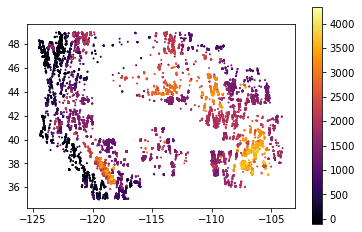

## Geographic coordinate sanity check
OK, great, Geopandas makes creating this plot a little easier than last week. 

Now, let's dig a little deeper and think about this map.

Note that the default aspect ratio for the above map is 'equal', so the x and y scaling is the same
* Check this by quickly using a piece of paper to measure the distance on your screen (in mm) covered by 10° on each axis 

## Questions
Discuss the following with your neighbor/group and provide answers in the notebook:

1. Are there any potential issues with this scaling for our geographic coordinates?

Do the following quick calculations for a spherical Earth (or attempt some more sophisticated geodetic distance calculations, if desired).  Drawing a quick sketch is likely useful as you think through this (no need to reproduce your sketch here).

2. What is the length (in km) of a degree of **latitude** at:  
    * 0° latitude (equator)
    * 90° latitude (pole)
    * 35° latitude?  49° latitude? (these are the min and max latitude values of the GLAS point data)

3. What is the length (in km) of a degree of **longitude** at:  
    * 0° latitude (equator)
    * 90° latitude (pole)
    * 35° latitude?  49° latitude?

4. Based on these values, does your map above have an equal aspect ratio in terms of true distance in km?

### Extra credit
Create a plot showing the length of a degree of longitude in km vs. latitude in decimal degrees for a range of 0 to 90 degrees latitude.  Add two red points for 35 and 49.

## Hmmm. So how do we deal with these scaling issues when using units of decimal degrees?

## Use a projected coordinate system!

We need to choose a map projection that is appropriate for our data. This decision is important for visualization, but is also critical for precise quantitative analysis. For example, if you want to compute area or volume change, you should use an equal-area projection. If you want to calculate distances between two points, you should use an equidistant projection.

https://www.axismaps.com/guide/general/map-projections/

Sadly, there is no "perfect" projection. You, as the mapmaker or data analyst, are responsible for choosing a projection with the right characteristics for your purposes. Let's explore a bit further, and we'll revisit some general guidelines later.

## Use GeoPandas to reproject your GeoDataFrame
* Start by reprojecting the points to a Universal Transverse Mercator (UTM), Zone 11N
    * You'll have to look up the appropriate EPSG code
* Store the output as a new GeoDataFrame
* Do a quick `head()` and note the new values in the `geometry` column

,decyear,ordinal,lat,lon,glas_z,dem_z,dem_z_std,lulc,geometry
0,2003.139571,731266.943345,44.157897,-105.356562,1398.51,1400.52,0.33,31,POINT (1431183.070 4955789.787)
1,2003.139571,731266.943346,44.150175,-105.358116,1387.11,1384.64,0.43,31,POINT (1431181.915 4954913.882)
2,2003.139571,731266.943347,44.148632,-105.358427,1392.83,1383.49,0.28,31,POINT (1431181.639 4954738.855)
3,2003.139571,731266.943347,44.147087,-105.358738,1384.24,1382.85,0.84,31,POINT (1431181.394 4954563.604)
4,2003.139571,731266.943347,44.145542,-105.359048,1369.21,1380.24,1.73,31,POINT (1431181.226 4954388.366)


## Create a new plot of the reprojected points
* Note the new coordinate system origin (0,0), units, and aspect ratio

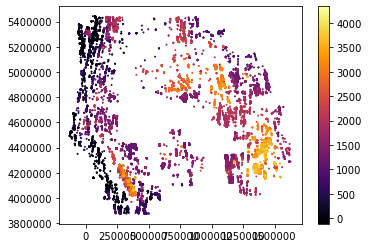

## Excellent, but what did we just do?

Under the hood, GeoPandas used the `pyproj` library (a Python API for PROJ) to transform each point from one coordinate system to another coordinate system.  

I guarantee that you've all done this kind of thing before, you may just not remember it or recognize it in this context. See: https://en.wikipedia.org/wiki/List_of_common_coordinate_transformations

In 2D, transforming (x,y) coordinates between different projections (e.g., WGS84 vs. UTM Zone 12N) on the same reference ellipsoid is pretty straightforward.  Things start to get more complicated when you include different ellipsoid models, horizontal/vertical datums, etc.  Oh, also the Earth's surface is not static - plate tectonics make everything more complicated, as time becomes important, and transformations must include a "kinematic" component.  

Fortunately, the `PROJ` library (https://proj.org/about.html) has generalized much of the complicated math for geodetic coordinate transformations.  It's been under development since the 1980s, and our understanding of the Earth's shape and plate motions has changed dramatically in that time period.  So, still pretty complicated, and there are different levels of support/sophistication in the tools/libraries that use `PROJ` (like `fiona` or `GeoPandas`).

We aren't going to get into the details here, but feel free to take a look at the Transformations section here to get a sense of how this is actually accomplished: https://proj.org/operations/index.html

## Define a custom projection for Western U.S.

The UTM projection we used above is not the best choice here for our data, which actually span 4 UTM zones:
https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system#/media/File:Utm-zones-USA.svg. 

We used Zone 12N, and while the map should have limited distortion within that zone centered on -110°W, map distortion increases beyond the width of the -114° to -108°W zone definition.

Let's instead use a custom Albers Equal Area projection to minimize area distoration over the full spatial extent of our GLAS points

To do this, we'll define a PROJ string (https://proj.org/usage/quickstart.html?highlight=definition), which can be interpreted by most Python geopackages (like `pyproj`).

The Albers Equal Area projection requires two standard parallels: https://proj.org/operations/projections/aea.html.  Here, we will also specify the center latitude and center longitude for the coordinate system origin.

* Define a custom Albers Equal Area proj string `'+proj=aea...'`
    * https://en.wikipedia.org/wiki/Albers_projection
    * PROJ reference, with example: https://proj.org/operations/projections/aea.html
    * Here is another sample proj string example for an Albers Equal Area projection of the U.S. (note that this uses GRS80 ellipsoid and NAD83 datum): http://spatialreference.org/ref/esri/102003/proj4/
        * For your string, please use WGS84 ellipsoid (see the proj doc for aea in the above link)
* Use the center longitude and center latitude you calculated earlier
* Define the two standard parallels (lines of latitude) based on the range of your points
    * Scale is true along these parallels, and distortion increases as you move away from these two parallels
    * One approach would be to use min and max latitude from the `total_bounds` extent computed earlier
        * This is fine, but note that this could lead to additional distortion near your center latitude
        * Extra Credit: figure out how to place them slightly inside your min and max latitude to minimize distortion across the entire latitude range
* Use Python string formatting to dynamically create your proj string (don't just hardcode your values, but substitute variables in the string)
* Print the final proj string

## Reproject the GLAS points to your custom projection

This is simple with the GeoDataFrame `to_crs()` method, which uses pyproj under the hood.

Store the output as a new GeoDataFrame and check that the `geometry` was updated.

## Create scatter plots for each of the three projections (WGS84, UTM, and custom AEA)

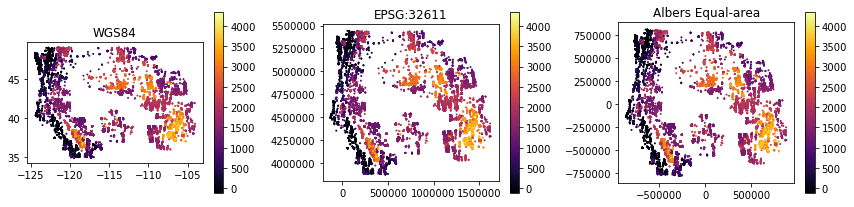

## Umm, they kind of look the same.  Why am I wasting time on this?

* Note the location of the origin for each coordinate system
    * The (0,0) should be near the center of your points for the AEA projection
* Note how points around edges of the plots are distorted

## Let's quantitatively compare the UTM and AEA projections
### Compute the total distance in meters between the min and max reprojected GLAS point coordinates (both x and y)
* Quickly discuss with your group: What do you expect?  Should they be equal?
    * Hint: are these equidistant projections?
* Compute the `total_bounds` for each projection
* Use these to compute dx and dy for each projection:
    * dx = max_x - min_x
    * dy = max_y - min_y
* Then compare the dx values for two projections, and repeat for dy values
    * dx2 = dx_utm - dx_aea
    * The difference values between the two projections should be in the range of ~1-20 km
* Compute the percent difference
    * Are the equal in the x and y direction?  Any ideas about why or why not?
    * Hint: think about distortion of universal transverse mercator projections in the y direction along the center longitude and in the x direction with distance from the center longitude
        * https://en.wikipedia.org/wiki/Transverse_Mercator_projection

## Extra Credit: Compute geodetic distances between lat/lon values as "truth"
* Integrate as standard exercise next year :)

### Check the area difference of the convex hulls
* Hopefully you've encountered this geometry concept before: https://en.wikipedia.org/wiki/Convex_hull
* Note: you'll want to use the GeoDataFrame `unary_union` method to aggregate all of the POINT objects as a MULTIPOINT object, then compute the convex_hull and area (can do this in one line by combining several methods/attributes with a `.`)
    * See API reference: https://geopandas.readthedocs.io/en/latest/reference.html
* Compute the percent area difference

## So what is going on here?
* You are seeing different types of distortion (distance, area) for the different projections.
* In this case, the differences are <1-2%, but they could be much larger if the points covered a greater extent, and maybe that <1-2% will introduce unacceptable (and unnecessary) error in subsequent analysis of distances or areas!
* It's important to pick a projection that is well-suited for your application.  If you care about accurate representation of distances, you should use an equidistant projection.  If you care about accurate representation of areas, use an equal-area projection.
* Remember, there's no "perfect" projection, so it's on you to account for this properly.  You would be surprised at how often errors due to projection decisions end up in published literature.
* Hopefully this was informative, and didn't just confuse the entire concept.  If you're lost, let's continue the discussion on Slack!

# Save the projected points to a GIS-ready file

## For convenience, let's create new GeoDataFrame columns to store the projected x and y coordinates in your AEA projection
* Note: don't _need_ to do this, as the geometry column already stores this information, but sometimes you want to preserve these if you're going to export as a csv or manipulate data outside of GeoPandas
* This should be pretty simple - no need for loops or a custom function here (hint: use the `x` and `y` attributes of the special `geometry` column).  Can store the projected x and y coordinates as new columns in your GeoDataFrame)

In [86]:
def gdf_add_xy(gdf):
    gdf['proj_x'] = gdf['geometry'].x
    gdf['proj_y'] = gdf['geometry'].y

## Save reprojected output to disk
* Use fiona to get a list of available file type drivers for output
* Note: the 'r' means fiona/geopandas can read this file type, 'w' means it can write this file type, 'a' means it can append to an existing file.
    * https://fiona.readthedocs.io/en/latest/manual.html#writing-vector-data

In [91]:
fiona.supported_drivers

{'AeronavFAA': 'r',
 'ARCGEN': 'r',
 'BNA': 'raw',
 'DXF': 'raw',
 'CSV': 'raw',
 'OpenFileGDB': 'r',
 'ESRIJSON': 'r',
 'ESRI Shapefile': 'raw',
 'GeoJSON': 'rw',
 'GeoJSONSeq': 'rw',
 'GPKG': 'rw',
 'GML': 'raw',
 'GPX': 'raw',
 'GPSTrackMaker': 'raw',
 'Idrisi': 'r',
 'MapInfo File': 'raw',
 'DGN': 'raw',
 'PCIDSK': 'r',
 'S57': 'r',
 'SEGY': 'r',
 'SUA': 'r',
 'TopoJSON': 'r'}

## How to choose a format?
* You've all used shapefiles in the past.  Please stop.  This is a legacy format, though it is still widely used.
* http://switchfromshapefile.org/
* Better options these days are Geopackage (GPKG) when spatial index is required, and simple GeoJSON for other cases
    * Both should be supported by any respectable GIS (including QGIS, ArcGIS, etc)
* Let's use geopackage for this exercise
* Now that you've made an informed decision, let's use the Geopandas `to_file()` method to create this file
    * Make sure you properly specify filename with extension and the `driver` option
    * *Note: Writing out may take a minute, and may produce an intermediate '.gpkg-journal' file*
        * Can see this in the file browser or terminal!

## 🎉

You can now directly load this gpkg file in any GIS, without defining a coordinate system or dealing with your original csv. You can also load this file directly into geopandas in the future using the `read_file()` method, without having to repeat the processing above. We'll do this for lab exercises in a few weeks. 

### See for yourself!

Try it! Right-click on file in the file browser to the left of the JupyterLab interface, then select Download and pick a location on your local computer (e.g., your Downloads folder). 

Then open this file in QGIS or ArcGIS on your local machine!

## A quick aside: `gdalsrsinfo`

We covered basic command line usage in Week 01.  We haven't discussed yet, but you will soon realize the power of the GDAL/OGR command-line utilities for batch data processing and quick geodata inspection. We will discuss more during raster module.

One of these utilties, `gdalsrsinfo`, is great for quickly inspecting datasets, dealing with srs and converting between different formats (proj4 string, EPSG, etc).

Open a new terminal, navigate to the directory where you just created the output file.  Run:
* `gdalsrsinfo yourfilename.gpkg`
* `gdalsrsinfo EPSG:32610`

By default, this will export a proj string and WKT for the crs.  You can also output different formats.  See `gdalsrsinfo -h` for usage.

Remember that you can also run shell commands directly within a Jupyter notebook using the `!cmd` syntax.  Try this here:


PROJ.4 : +proj=aea +lat_0=42 +lon_0=-114.27 +lat_1=37.31 +lat_2=46.69 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

OGC WKT2:2018 :
PROJCRS["unknown",
    BASEGEOGCRS["unknown",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["unnamed",
        METHOD["Albers Equal Area",
            ID["EPSG",9822]],
        PARAMETER["Latitude of false origin",42,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8821]],
        PARAMETER["Longitude of false origin",-114.27,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8822]],
        PARAMETER["Latitude of 1st standard parallel",37.31,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8823]],
        PARAMETER["Latitude of 2nd standard parallel",46.69,
         

# Part 3: Let's mix some points and polygons

## Get polygons for US States

Hmmm, let's see.  Two choices:
1. We could go to ESRI or the U.S. Census website, identify and download a shapefile, unzip 4+ files, copy/paste the appropriate \*.shp filename into the notebook.  Wait, how can I download on a remote server?  OK, maybe run something like `wget http://...`, unzip, provide absolute path  
*- OR -*
2. Give geopandas a url string that points to a GeoJSON file somewhere on the web, and read dynamically

Yeah, let's go with #2

Let's use the US States 5M GeoJSON here: http://eric.clst.org/tech/usgeojson/

* We've talked about JSON as the text format used by Jupyter notebooks. GeoJSON extends this format to include geospatial information. It's pretty great. If you are unfamiliar, take a moment to read about GeoJSON: https://en.wikipedia.org/wiki/GeoJSON

Take a moment to look at the 5M file contents in your browser or download and open with a text editor.  Note organization structure.  How does this compare to, say, a Python dictionary object? 

This is a GeoJSON file!

Read the file using GeoPandas.

In [104]:
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json'
#states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_20m.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ..."
1,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-166.10574 53.98861, -166.0752..."
2,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0..."
3,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079..."
4,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-122.42144 37.86997, -122.4213..."


## Inspect the GeoDataFrame
* Note the columns and geometry type(s) in the `geometry` columns

## Do a quick `plot()` to preview

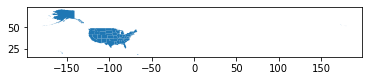

In [126]:
states_gdf.plot();

*Note: The extent of the Aleutian islands (Alaska) crosses the -180/+180°W antimeridian, which is why the extent spans the full longitude range.*

## Check the CRS
* Note that this was already defined during import.  Thanks Geopandas!

In [106]:
states_gdf.crs

{'init': 'epsg:4326'}

## Let's compute the area (in km^2) for all states in the GeoDataFrame
* Our GeoDataFrame of states is still in geographic coordinates (decimal degrees)
    * We could compute area in decimal degrees, but remember our analysis above about how the length of a degree of longitude varies? This will also affect area calculations.
    * We want polygon area values in km<sup>2</sup>
    * What might you need to do to the GeoDataFrame before you proceed?
        * Hint you did this several times earlier!
        * ...

### Answer: you need to reproject the state polygon GeoDataFrame!
* Let's start by using the UTM projection we explored earlier
* Do a quick `head()` on the output to verify a change in geometry coordinates

## Now compute the area of the projected GeoDataFrame
* Compute the area for each state in km^2
    * Don't use a loop - this should be simple using geopandas: https://geopandas.readthedocs.io/en/latest/reference.html
* Compare your values with the values in the `CENSUSAREA` column
    * Calculate differences as a percentage of the `CENSUSAREA` 
    * Note: `CENSUSAREA` values are in square miles (sigh), so you'll need to convert to square km
* Do your numbers agree?  If not, any guess about why not? (discuss with your neighbor)
    * Maybe sort your GeoDataFrame by percent difference
    * What do you notice about the states with largest difference - how far are they from the UTM zone center longitude?

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,myarea,CENSUSAREA_km2,area_diff,area_diff_perc
51,0400000US72,72,Puerto Rico,,3423.775,"MULTIPOLYGON (((6635080.448 3115452.302, 66328...",19466.473604,8867.543012,10598.930592,119.524998
11,0400000US15,15,Hawaii,,6422.628,"MULTIPOLYGON (((-3800700.817 2804740.075, -380...",25861.443104,16634.542294,9226.900810,55.468318
8,0400000US11,11,District of Columbia,,61.048,"POLYGON ((4012295.260 5137712.739, 4011713.660...",236.001183,158.113710,77.887474,49.260418
39,0400000US44,44,Rhode Island,,1033.814,"MULTIPOLYGON (((4317771.260 5724730.753, 43176...",3989.615923,2677.567922,1312.048002,49.001483
19,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((4242267.978 6037807.501, 42421...",116413.511258,79882.862141,36530.649117,45.730271


## Now, repeat the above analysis using your Albers Equal Area projection
* Note how the area differences change
* Might be useful to plot the two side by side (note distortion for Alaska!)
* Hopefully this helps to reinforce what touched on earlier with distances and the area of the convex hulls calculated for the same projections earlier

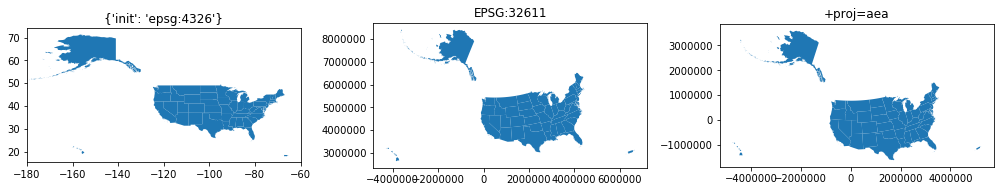

## Extra credit: Create a clorpleth plot for each projection showing the percent area difference for each state

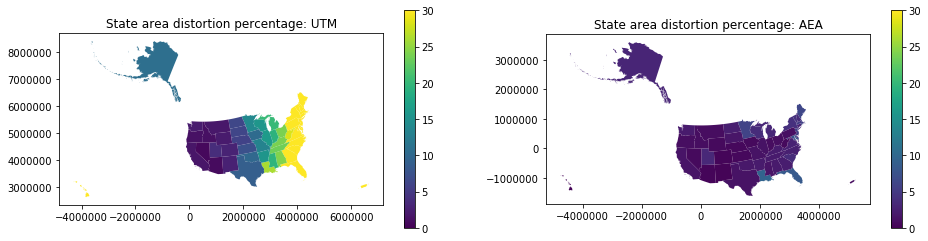

*DES Note: I'm not entirely clear why there are small area differences between `CENSUSAREA` and our equal-area polygons - maybe something about coastline distances vs area?  But using 20M or 500K polygons doesn't make much of a difference. :man-shrugging: Need to revisit this...*

## Create a combined plot of state outlines and GLAS points
You already reprojected both the GLAS points GeoDataFrame and the states GeoDataFrame to the same AEA projected coordinate system with units of meters.  Let's add both to the same plot, so we have better context for our points!

See documentation here: https://geopandas.readthedocs.io/en/latest/mapping.html#maps-with-layers

* Use the matplotlib object-oriented interface to plot on the same axes:
    * See notes here: https://matplotlib.org/api/api_overview.html
    * Remember that the GeoDataFrame `plot()` function returns a matplotlib.axes object by default
    * Plot the reprojected states GeoDataFrame and store the output as a new variable named `myax`
        * Note that you no longer see `<matplotlib.axes._subplots.AxesSubplot at 0x7f0da85f5a58>` output in the notebook
        * Note that you can continue to update/modify the axes (e.g., add a title) by modifying your `myax` object
    * Now plot the reprojected ICESat point GeoDataFrame, passing `myax` to the `ax` keyword
        * I recommend using `facecolor='white'` and `edgecolor='black'`
    * You should see your points drawn over the state polygons!
* Make sure you get the plotting order correct, or appropriately set the `facecolor` and `edgecolor` keyword arguments for transparency

## OK, that looks good, but how do we limit to the Western US

### Get the total bounding box (or extent) of the *reprojected* GLAS points
* Hint: you did this earlier for the original lat/lon GeoDataFrame, should be easy to repeat for your projected GeoDataFrame.

### Update your GLAS scatterplot and set the x and y limits to your projected bounds
* You should see your points with state borders overlaid for context

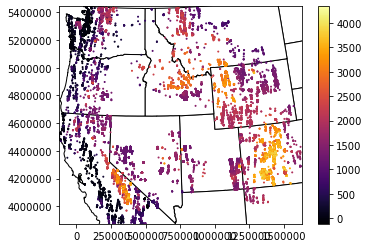

### Extra Credit: create a function to pad the bounds by user-specified distance
* Assume the user knows the units of their projection, and specifies this distance appropriately (e.g., 20000 meters, not 20000 degrees)
* Play with padding distances and replot for a visually pleasing extent (i.e., don't chop off California)

## Summary

OK, we covered a lot of ground with this one.  These concepts are fundemental to all aspects of geospatial data analysis, and we'll see them throughout the rest of the quarter.

* Hopefully you got a sense of how we can define projections (using EPSG codes, proj strings), and understand some of the tradeoffs between different projections for different objectives for your map visualization or measurements.
* One important takeaway - make sure all of your input datasets use the same coordinate system, which may require reprojecting one to match another.  You can then plot them on the same axes to create more informative plots.
* We covered basic operations, plotting, functions and attributes of Geopandas GeoDataFrame objects, which are a great option for most vector datasets.